In [4]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random

import utilities as ut
import modularised_utils as mut

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

In [5]:
experiment = 'slc'
path = f"data/{experiment}/results"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")


In [6]:
# Load the dictionaries containing the results for each optimization method
diroca_results = joblib.load(f"{path}/diroca_cv_results.pkl")
gradca_results = joblib.load(f"{path}/gradca_cv_results.pkl")
baryca_results = joblib.load(f"{path}/baryca_cv_results.pkl")

print("Successfully loaded results for all optimization methods.")
print(f"  - DIROCA results keys: {list(diroca_results.keys())}")
print(f"  - GradCA results keys: {list(gradca_results.keys())}")
print(f"  - BARYCA results keys: {list(baryca_results.keys())}")

results_to_evaluate = {}

# --- Add the baseline methods first ---
results_to_evaluate['GradCA'] = gradca_results
results_to_evaluate['BARYCA'] = baryca_results
# results_to_evaluate['Abs-LiNGAM'] = abslingam_results

# --- Unpack each DIROCA hyperparameter run into its own "method" ---
# First, find all the different DIROCA runs you tested (e.g., 'eps_delta_2', 'eps_delta_4')
# We can find them by looking at the keys in the first fold's results.
if diroca_results:
    first_fold_key = list(diroca_results.keys())[0]
    diroca_run_ids = list(diroca_results[first_fold_key].keys())

    # Now, create a separate entry for each DIROCA run
    for run_id in diroca_run_ids:
        # Create a new, descriptive name for this method, e.g., "DIROCA (eps_delta_8)"
        method_name = f"DIROCA ({run_id})"
        
        # Create a new dictionary that will only contain the results for this specific run_id
        new_diroca_dict = {}
        for fold_key, fold_results in diroca_results.items():
            # For each fold, just grab the data for the current run_id
            if run_id in fold_results:
                new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
        
        # Add this new, filtered dictionary to our main evaluation dictionary
        results_to_evaluate[method_name] = new_diroca_dict

print("\nMethods available for evaluation:")
for key in results_to_evaluate.keys():
    print(f"  - {key}")

Successfully loaded results for all optimization methods.
  - DIROCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
  - GradCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']
  - BARYCA results keys: ['fold_0', 'fold_1', 'fold_2', 'fold_3', 'fold_4']

Methods available for evaluation:
  - GradCA
  - BARYCA
  - DIROCA (eps_delta_4)
  - DIROCA (eps_delta_8)
  - DIROCA (eps_delta_1)
  - DIROCA (eps_delta_2)
  - DIROCA (eps_delta_0.111)


In [7]:
# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'slc'.


### Helper functions

In [8]:
def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
    """
    Calculates the abstraction error for a given T matrix on a test set.

    This function works in the space of distribution parameters:
    1. It estimates Gaussian parameters (mean, cov) from the LL and HL test samples.
    2. It transforms the LL Gaussian's parameters using the T matrix.
    3. It computes the Wasserstein distance between the transformed LL distribution
       and the actual HL distribution.
    
    Args:
        T_matrix (np.ndarray): The learned abstraction matrix.
        Dll_test (np.ndarray): The low-level endogenous test samples.
        Dhl_test (np.ndarray): The high-level endogenous test samples.
        
    Returns:
        float: The calculated Wasserstein-2 distance.
    """
    # 1. Estimate parameters from the low-level test data
    mu_L_test    = np.mean(Dll_test, axis=0)
    Sigma_L_test = np.cov(Dll_test, rowvar=False)

    # 2. Estimate parameters from the high-level test data
    mu_H_test    = np.mean(Dhl_test, axis=0)
    Sigma_H_test = np.cov(Dhl_test, rowvar=False)

    # 3. Transform the low-level parameters using the T matrix
    # This projects the low-level distribution into the high-level space
    mu_V_predicted    = mu_L_test @ T_matrix.T
    Sigma_V_predicted = T_matrix @ Sigma_L_test @ T_matrix.T
    
    # 4. Compute the Wasserstein distance between the two resulting Gaussians
    try:
        wasserstein_dist = np.sqrt(mut.compute_wasserstein(mu_V_predicted, Sigma_V_predicted, mu_H_test, Sigma_H_test))
    except Exception as e:
        print(f"  - Warning: Could not compute Wasserstein distance. Error: {e}. Returning NaN.")
        return np.nan

    return wasserstein_dist

In [18]:

def apply_shift(clean_data, shift_config, all_var_names, model_level):
    """
    Applies a specified contamination to the test data.
    - Handles different shift types (additive, multiplicative).
    - Handles different distributions (gaussian, student-t, exponential).
    - Handles selective application to a subset of variables.
    """

    shift_type = shift_config.get('type')
    dist_type  = shift_config.get('distribution', 'gaussian')

    n_samples, n_dims = clean_data.shape

    # Select the correct parameter dictionary for the current model level
    level_key = 'll_params' if model_level == 'L' else 'hl_params'
    params = shift_config.get(level_key, {})
    
    # --- 1. Generate the full noise matrix based on the specified distribution ---
    noise_matrix = np.zeros_like(clean_data)
    if dist_type == 'gaussian':
        mu           = np.array(params.get('mu', np.zeros(n_dims)))
        sigma_def    = params.get('sigma', np.eye(n_dims))
        sigma        = np.diag(np.array(sigma_def)) if np.array(sigma_def).ndim == 1 else np.array(sigma_def)
        noise_matrix = np.random.multivariate_normal(mean=mu, cov=sigma, size=n_samples)

    elif dist_type == 'student-t':
        df           = params.get('df', 3)
        loc          = np.array(params.get('loc', np.zeros(n_dims)))
        shape_def    = params.get('shape', np.eye(n_dims))
        shape        = np.diag(np.array(shape_def)) if np.array(shape_def).ndim == 1 else np.array(shape_def)
        noise_matrix = stats.multivariate_t.rvs(loc=loc, shape=shape, df=df, size=n_samples)

    elif dist_type == 'exponential':
        scale        = params.get('scale', 1.0)
        noise_matrix = np.random.exponential(scale=scale, size=(n_samples, n_dims))
    
    # --- 2. Apply noise selectively if specified ---
    final_noise = np.zeros_like(clean_data)
    vars_to_affect = params.get('apply_to_vars')

    if vars_to_affect is None:
        # If not specified, apply noise to all variables
        final_noise = noise_matrix
    else:
        # If specified, apply noise only to the selected columns
        try:
            indices_to_affect = [all_var_names.index(var) for var in vars_to_affect]
            final_noise[:, indices_to_affect] = noise_matrix[:, indices_to_affect]
        except ValueError as e:
            print(f"Warning: A variable in 'apply_to_vars' not found. Error: {e}")
            return clean_data # Return clean data if there's a config error

    # --- 3. Return the contaminated data ---
    if shift_type == 'additive':
        return clean_data + final_noise
    elif shift_type == 'multiplicative':
        return clean_data * final_noise
    else:
        raise ValueError(f"Unknown shift type: {shift_type}")

In [19]:
def apply_huber_contamination(clean_data, alpha, shift_config, all_var_names, model_level, seed=42):
    """
    Contaminates a dataset using the Huber model. A fraction 'alpha' of the
    samples are replaced with noisy versions.

    Args:
        clean_data (np.ndarray): The original, clean test data samples.
        alpha (float): The fraction of data to contaminate (between 0 and 1).
        shift_config (dict): Configuration defining the noise for the outliers.
        all_var_names (list): List of all variable names for this data.
        model_level (str): 'L' for low-level or 'H' for high-level.
        
    Returns:
        np.ndarray: The new, contaminated test data.
    """
    #np.random.seed(seed)
    if not (0 <= alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    if alpha == 0:
        return clean_data
    
    # Create the fully noisy version of the data using our existing function
    noisy_data = apply_shift(clean_data, shift_config, all_var_names, model_level)
    
    if alpha == 1:
        return noisy_data
        
    n_samples = clean_data.shape[0]
    n_to_contaminate = int(alpha * n_samples)
    
    # Randomly select which rows to replace
    indices_to_replace = np.random.choice(n_samples, n_to_contaminate, replace=False)
    
    # Start with a copy of the clean data
    contaminated_data = clean_data.copy()
    
    # Replace the selected rows with their noisy versions
    contaminated_data[indices_to_replace] = noisy_data[indices_to_replace]
    
    return contaminated_data

In [20]:
def plot_robustness_curves(results_df):
    """
    Plots the abstraction error as a function of contamination strength for each method.
    """
    plt.figure(figsize=(12, 8))
    
    sns.lineplot(
        data=results_df, 
        x='noise_scale', 
        y='error', 
        hue='method', 
        marker='o',
        errorbar=('ci', 95) # Show 95% confidence interval
    )
    
    plt.title('Robustness Curve: Abstraction Error vs. Noise Level', fontsize=16)
    plt.xlabel('Contamination Strength (Noise Scale)', fontsize=12)
    plt.ylabel('Average Abstraction Error (Wasserstein Distance)', fontsize=12)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()


def perform_statistical_tests(results_df, method1, method2, test_type='paired-t'):
    """
    Compares two methods at each noise level using a statistical test.
    """
    print(f"\n--- Statistical Significance Test: {method1} vs. {method2} ({test_type}) ---")
    
    df_sorted = results_df.sort_values('fold')
    noise_levels = sorted(df_sorted['noise_scale'].unique())
    
    for level in noise_levels:
        df_level = df_sorted[df_sorted['noise_scale'] == level]
        
        errors1 = df_level[df_level['method'] == method1]['error'].dropna()
        errors2 = df_level[df_level['method'] == method2]['error'].dropna()

        if len(errors1) != len(errors2) or len(errors1) < 2:
            print(f"  - At Noise Level {level:.2f}: Not enough data to perform test.")
            continue
            
        # Perform statistical test
        if test_type == 'paired-t':
            stat, p_value = stats.ttest_rel(errors1, errors2)
        elif test_type == 'wilcoxon':
            # Wilcoxon is for paired, non-parametric data
            stat, p_value = stats.wilcoxon(errors1, errors2)
        else: # Independent t-test
            stat, p_value = stats.ttest_ind(errors1, errors2)

        # Report the result
        print(f"  - At Noise Level {level:.2f}: p-value = {p_value:.4f}", end="")
        if p_value < 0.05:
            winner = method1 if np.mean(errors1) < np.mean(errors2) else method2
            print(f" (Significant difference, {winner} is better)")
        else:
            print(" (No significant difference)")

### Main Evaluation Block

In [34]:
alpha_values = np.linspace(0, 1.0, 5) 
noise_levels = np.linspace(0, 10.0, 5)
num_trials = 1
zero_mean = True
base_sigma_L = np.eye(len(all_data['LLmodel']['graph'].nodes()))
base_sigma_H = np.eye(len(all_data['HLmodel']['graph'].nodes()))

evaluation_records = []
for alpha in tqdm(alpha_values, desc="Alpha Levels"):
    for scale in noise_levels:
        for trial in range(num_trials):
            for i, fold_info in enumerate(saved_folds):
                for method_name, results_dict in results_to_evaluate.items():
                    
                    fold_results = results_dict[f'fold_{i}']
                    for run_key, run_data in fold_results.items():
                        
                        T_learned = run_data['T_matrix']
                        test_indices = run_data['test_indices']
                        
                        errors_per_intervention = []
                        for iota in I_ll_relevant:

                            Dll_test_clean = Dll_samples[iota][test_indices]
                            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                            
                            if zero_mean:
                                mu_scale_L = np.zeros(base_sigma_L.shape[0])
                                mu_scale_H = np.zeros(base_sigma_H.shape[0])
                            else:
                                mu_scale_L = np.ones(base_sigma_L.shape[0])*scale
                                mu_scale_H = np.ones(base_sigma_H.shape[0])*scale
                            
                            sigma_scale_L = base_sigma_L * (scale**2)
                            sigma_scale_H = base_sigma_H * (scale**2)

                            shift_config = {
                                'type': 'additive', 'distribution': 'gaussian',
                                'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
                                'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H}
                            }
                            
                            Dll_test_contaminated = apply_huber_contamination(Dll_test_clean, alpha, shift_config, ll_var_names, 'L', seed=trial)
                            Dhl_test_contaminated = apply_huber_contamination(Dhl_test_clean, alpha, shift_config, hl_var_names, 'H', seed=trial)
                            
                            error = calculate_abstraction_error(T_learned, Dll_test_contaminated, Dhl_test_contaminated)
                            if not np.isnan(error):
                                errors_per_intervention.append(error)
                        
                        avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                        
                        record = {
                            'method': method_name,
                            'alpha': alpha,
                            'noise_scale': scale,
                            'trial': trial,
                            'fold': i,
                            'error': avg_error
                        }
                        evaluation_records.append(record)

final_results_df = pd.DataFrame(evaluation_records)

print("--- Full Evaluation Complete ---")

Alpha Levels: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it]

--- Full Evaluation Complete ---


### 0-shift

In [35]:
df_clean             = final_results_df[final_results_df['alpha']==0.0]
summary_stats        = df_clean.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])

print("--- Final Summary (Mean Error ± SEM) ---")

# 2. Now, print the results in your custom table format
print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean Error ± Standard Error of Mean (SEM)'}")
print("="*65)

# The 'method' is now in the index of the summary table
for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    # The method_name from the index is already the clean display name
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)

--- Final Summary (Mean Error ± SEM) ---

Method/Run                                    | Mean Error ± Standard Error of Mean (SEM)
BARYCA                                        |  7.5448 ± 0.0016
DIROCA (eps_delta_0.111)                      |  7.3967 ± 0.0046
DIROCA (eps_delta_1)                          |  7.7972 ± 0.0062
DIROCA (eps_delta_2)                          |  7.6567 ± 0.0075
DIROCA (eps_delta_4)                          |  8.1671 ± 0.0072
DIROCA (eps_delta_8)                          |  8.7413 ± 0.0040
GradCA                                        | 12.2711 ± 0.0138


### Point comparison

In [36]:
alpha_point = 1.0
noise_level_point = 5.0

df_point            = final_results_df[(final_results_df['alpha']==alpha_point) & (final_results_df['noise_scale']==noise_level_point)]
summary_stats        = df_point.groupby(['method'])['error'].agg(['mean', 'std', 'count'])
summary_stats['sem'] = summary_stats['std'] / np.sqrt(summary_stats['count'])

print("--- Final Summary (Mean Error ± SEM) ---")

# 2. Now, print the results in your custom table format
print("\n" + "="*65)
print(f"{'Method/Run':<45} | {'Mean Error ± Standard Error of Mean (SEM)'}")
print("="*65)

# The 'method' is now in the index of the summary table
for method_name, row in summary_stats.iterrows():
    mean_val = row['mean']
    sem_val = row['sem']
    
    # The method_name from the index is already the clean display name
    print(f"{method_name:<45} | {mean_val:>7.4f} ± {sem_val:.4f}")

print("="*65)

--- Final Summary (Mean Error ± SEM) ---

Method/Run                                    | Mean Error ± Standard Error of Mean (SEM)
BARYCA                                        | 37.8504 ± 0.0473
DIROCA (eps_delta_0.111)                      | 43.3316 ± 0.0700
DIROCA (eps_delta_1)                          | 19.5411 ± 0.0391
DIROCA (eps_delta_2)                          | 17.2413 ± 0.0419
DIROCA (eps_delta_4)                          |  6.1681 ± 0.0073
DIROCA (eps_delta_8)                          |  6.3508 ± 0.0246
GradCA                                        | 49.3188 ± 0.1065


In [37]:
label_map = {
    'DIROCA (eps_delta_0.111)': r'DiRoCA$_{\epsilon_\ell^*, \epsilon_h^*}$',
    'DIROCA (eps_delta_1)':     r'DiRoCA$_{1,1}$',
    'DIROCA (eps_delta_2)':     r'DiRoCA$_{2,2}$',
    'DIROCA (eps_delta_4)':     r'DiRoCA$_{4,4}$',
    'DIROCA (eps_delta_8)':     r'DiRoCA$_{8,8}$',
    'GradCA':                   r'GRAD$_{(\tau, \omega)}$',
    'BARYCA':                   r'GRAD$_{\text{bary}}$',
    'Abs-LiNGAM (Perfect)':     r'AbsLin$_{\text{p}}$', 
    'Abs-LiNGAM (Noisy)':       r'AbsLin$_{\text{n}}$'
}

### Fixed alpha curve

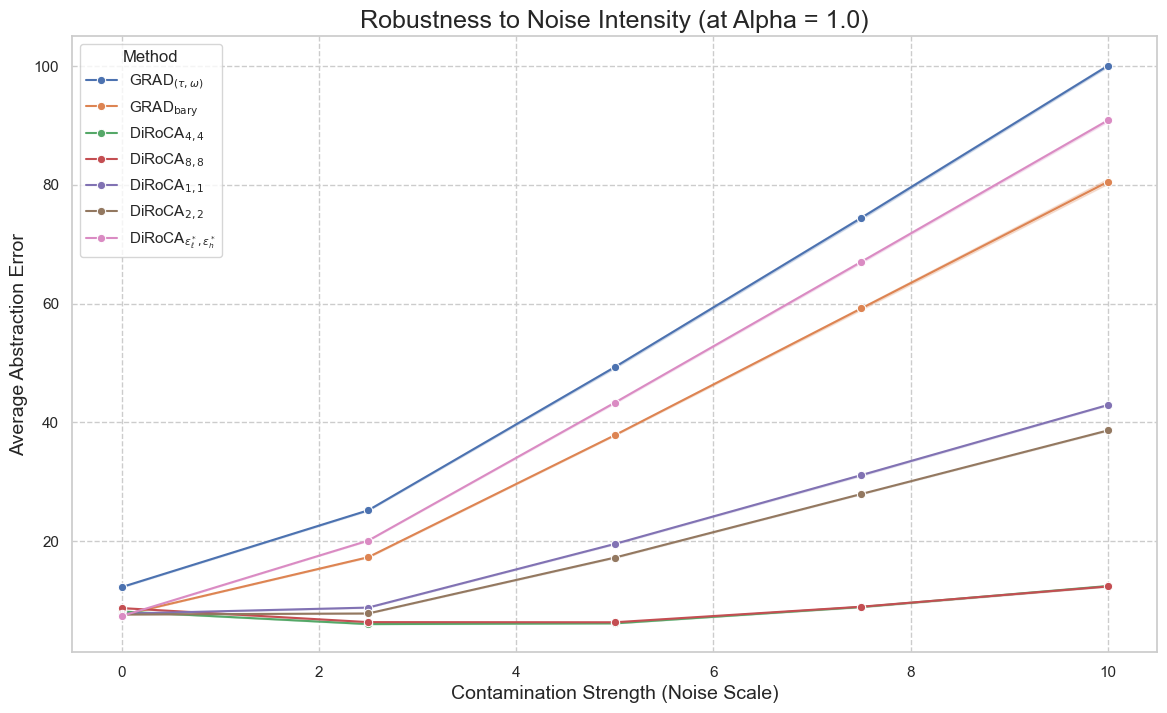

In [38]:
alpha_to_plot = 1.0

df_subset = final_results_df[final_results_df['alpha'] == alpha_to_plot]

if df_subset.empty:
    print(f"Warning: No data found for alpha ≈ {alpha_to_plot}. Please check the 'alpha_values' in your experiment.")
else:
    df_for_plotting = df_subset.copy()
    df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=df_for_plotting,
        x='noise_scale',
        y='error',
        hue='display_name',
        marker='o',
        linewidth=1.5,
        errorbar=('ci', 95) # Shaded area is the 95% CI across folds and trials
    )
    plt.title(f'Robustness to Noise Intensity (at Alpha = {alpha_to_plot})', fontsize=18)
    plt.xlabel('Contamination Strength (Noise Scale)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

In [ ]:
alpha_values = sorted(final_results_df['alpha'].unique())

df_for_plotting = final_results_df.copy()
df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)


fig, ax = plt.subplots(figsize=(14, 8))
y_max   = final_results_df['error'].max()


def update_alpha(alpha):
    ax.clear() # Clear the previous frame
    
    # Filter the data for the current alpha value
    df_subset = df_for_plotting[np.isclose(df_for_plotting['alpha'], alpha)]
    
    # Draw the lineplot for this frame
    sns.lineplot(
        data=df_subset,
        x='noise_scale',
        y='error',
        hue='display_name',
        marker='o',
        errorbar=('ci', 95),
        ax=ax
    )
    
    ax.set_title(f'Robustness to Noise Intensity (at Alpha = {alpha:.2f})', fontsize=18)
    ax.set_xlabel('Contamination Strength (Noise Scale)', fontsize=14)
    ax.set_ylabel('Average Abstraction Error', fontsize=14)
    ax.legend(title='Method')
    ax.grid(True, which='both', linestyle='--')
    ax.set_ylim(0, y_max * 1.1) # Keep y-axis consistent


print("Creating animation for evolving alpha...")
ani_alpha = FuncAnimation(fig, update_alpha, frames=alpha_values, blit=False, repeat=False)

# Save the GIF
ani_alpha.save('robustness_vs_noise_evolving_alpha.gif', writer='pillow', fps=2)
plt.close() # Prevent the final static plot from showing

print("✓ Animation saved as 'robustness_vs_noise_evolving_alpha.gif'")
# HTML(ani_alpha.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating animation for evolving alpha...


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


✓ Animation saved as 'robustness_vs_noise_evolving_alpha.gif'


### Fix noise curve

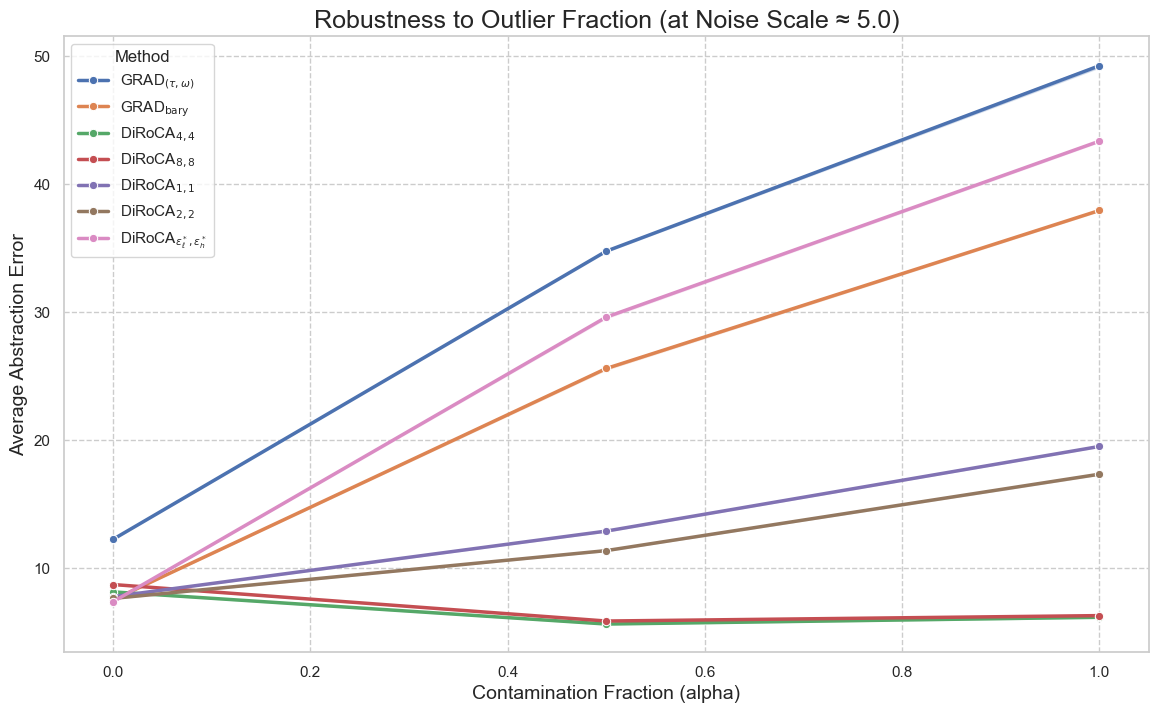

In [27]:
noise_level_to_plot = 5.0

df_subset = final_results_df[final_results_df['noise_scale'] == noise_level_to_plot]

if df_subset.empty:
    print(f"Warning: No data found for noise_scale ≈ {noise_level_to_plot}.")
else:
    df_for_plotting = df_subset.copy()
    df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=df_for_plotting,
        x='alpha',
        y='error',
        hue='display_name',
        marker='o',
        linewidth=2.5,
        errorbar=('ci', 95)
    )

    plt.title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {noise_level_to_plot})', fontsize=18)
    plt.xlabel('Contamination Fraction (alpha)', fontsize=14)
    plt.ylabel('Average Abstraction Error', fontsize=14)
    plt.legend(title='Method')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

In [278]:
noise_levels = sorted(final_results_df['noise_scale'].unique())

df_for_plotting = final_results_df.copy()
df_for_plotting['display_name'] = df_for_plotting['method'].map(label_map)

fig, ax = plt.subplots(figsize=(14, 8))
y_max = final_results_df['error'].max()

def update_noise(scale):
    ax.clear()
    
    # Filter the data for the current noise scale
    df_subset = df_for_plotting[np.isclose(df_for_plotting['noise_scale'], scale)]
    
    # Draw the lineplot for this frame
    sns.lineplot(
        data=df_subset,
        x='alpha',
        y='error',
        hue='display_name',
        marker='o',
        errorbar=('ci', 95),
        ax=ax
    )
    
    ax.set_title(f'Robustness to Outlier Fraction (at Noise Scale ≈ {scale:.2f})', fontsize=18)
    ax.set_xlabel('Contamination Fraction (alpha)', fontsize=14)
    ax.set_ylabel('Average Abstraction Error', fontsize=14)
    ax.legend(title='Method')
    ax.grid(True, which='both', linestyle='--')
    ax.set_ylim(0, y_max * 1.1)


print("Creating animation for evolving noise scale...")
ani_noise = FuncAnimation(fig, update_noise, frames=noise_levels, blit=False, repeat=False)

# Save the GIF
ani_noise.save('robustness_vs_alpha_evolving_noise.gif', writer='pillow', fps=2)
plt.close()

print("✓ Animation saved as 'robustness_vs_alpha_evolving_noise.gif'")
# HTML(ani_noise.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Creating animation for evolving noise scale...


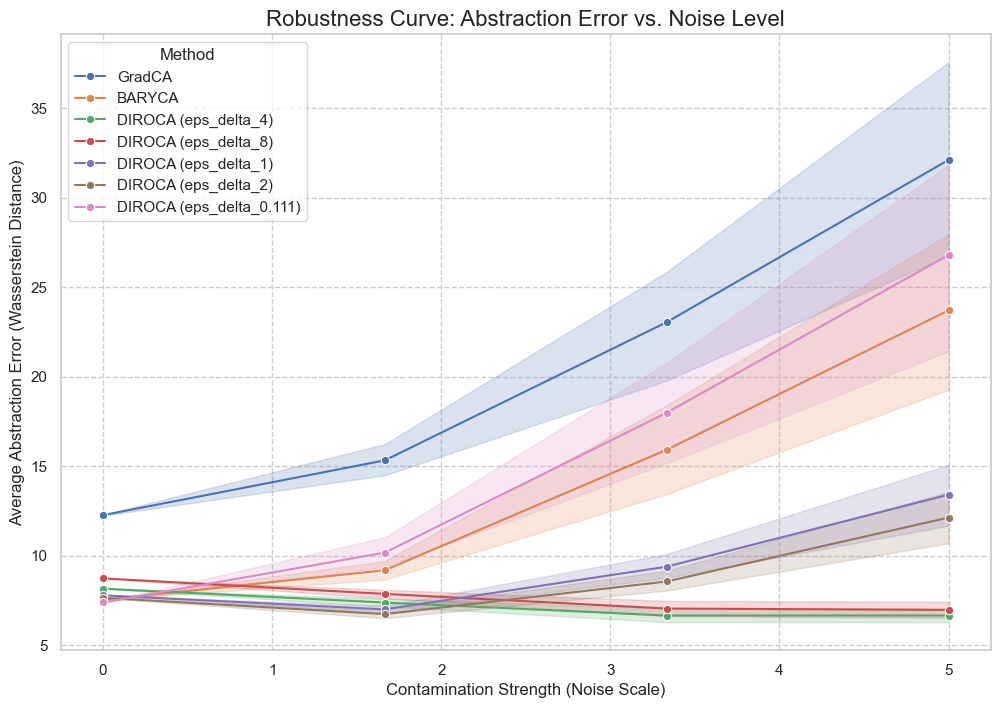

In [28]:
# First, generate the main plot
plot_robustness_curves(final_results_df)

# # Then, run statistical tests to compare pairs of methods
# # A paired t-test is appropriate here because the methods are tested on the same k-fold splits.
# perform_statistical_tests(final_results_df, 'DIROCA', 'GradCA', test_type='paired-t')
# perform_statistical_tests(final_results_df, 'DIROCA', 'BARYCA', test_type='paired-t')